# 2 Data Checking
10-10-2024

## Env

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys
import os
from dotenv import load_dotenv

load_dotenv()

True

### Make Database Connection

In [8]:
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy import text

user = "postgres"
password = os.getenv('POSTGRES_PW')
host = "127.0.0.1"
port = "5432"
database = "gradschool"

pg_url = URL.create(
    drivername='postgresql',
    username='postgres',
    host='127.0.0.1',
    database='gradschool',
    password=os.getenv('POSTGRES_PW')
)

pg_engine = create_engine(pg_url)
# Test connection
try:
    with pg_engine.connect() as connection_str:
        print('Successfully connected to the PostgreSQL database')
except Exception as ex:
    print(f'Sorry failed to connect: {ex}')

pg_connection = pg_engine.connect()

Successfully connected to the PostgreSQL database


## Load Tables

### Files from `1_data_wrangling`
* CA BGs
* Tagged slip lanes
* Replica Link Volumes
* TIMS (Berk/Oakland) (or Alameda?)

In [9]:
# # Load all the cleaned datasets directly from PG

# # Load Test File of CA bgs
try:
    shp_tl_CA_bgs_2020 = gpd.read_postgis(text('SELECT * FROM "mapping_basefiles"."tl_CA_bgs_2020";'), con = pg_connection)
    print('CA BGs Loaded..')
except Exception as error:
    print('Failed:', error)

# # Slip Lanes
#gdf_tagged_slip_lanes = gpd.read_postgis('select *, geometry as geom from slip_lanes.alameda_tagged_slip_lanes_clean;', con = pg_connection).drop('geometry', axis=1)
try:
    gdf_tagged_slip_lanes = gpd.read_postgis('select * from slip_lanes.alameda_tagged_slip_lanes_clean;', con = pg_connection)
    print('Slip lanes Loaded..')
except Exception as error:
    print('Failed:', error)

# # Replica Link Volumes
try:
    gdf_network_link_volumes = gpd.read_postgis('select *, geometry as geom from slip_lanes.replica_netlinkvols_alameda_fall2023;', con = pg_connection).drop('geometry', axis=1)
    print('Replica Data Loaded..')
except Exception as error:
    print('Failed:', error)

# TIMS/SWITRS Dataset from Oakland/Berkeley
try:
    gdf_TIMS = gpd.read_postgis('select *, geometry as geom from slip_lanes.tims_alameda_county;', con=pg_connection)#.drop('geometry', axis = 1)
    print('Tims Dataset Loaded..')
except Exception as error:
    print('Failed:', error)

CA BGs Loaded..
Slip lanes Loaded..
Replica Data Loaded..
Tims Dataset Loaded..


## Test with Basic Visualization

In [10]:
#gdf_tagged_slip_lanes.groupby('Valid').sum()
gdf_tagged_slip_lanes_valid = gdf_tagged_slip_lanes[gdf_tagged_slip_lanes['Valid']]

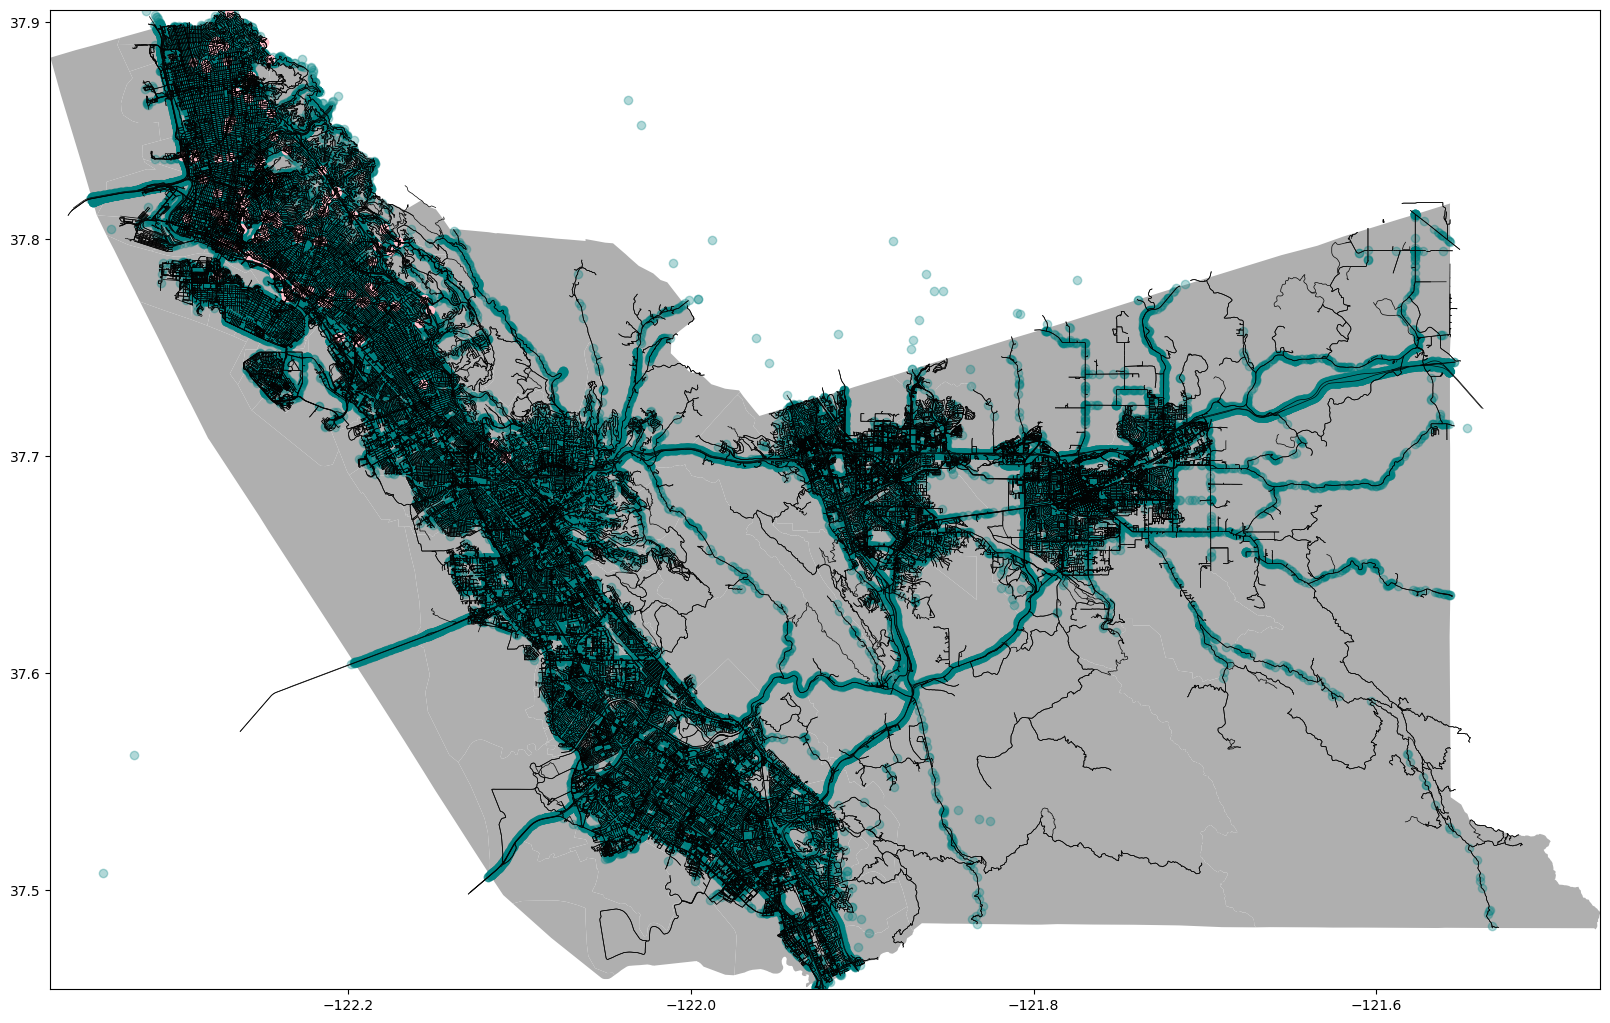

In [13]:
# Basic Pyplot
# Plot them to see how things are aligning so far
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 15))
shp_tl_CA_bgs_2020[shp_tl_CA_bgs_2020['countyfp'] == '001'].plot(ax=ax, color = '#afafaf')
gdf_network_link_volumes.plot(ax=ax, color='#030303', lw = .5)
gdf_TIMS.plot(ax=ax, color = 'teal', alpha=.3)
gdf_tagged_slip_lanes_valid.plot(ax=ax, color = 'pink')

# Get the extents (bounding box) of the layer
xmin, ymin, xmax, ymax = shp_tl_CA_bgs_2020[shp_tl_CA_bgs_2020['countyfp'] == '001'].total_bounds

# Now Set Extents
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Show the plot
plt.show()


Questions:
- Why are there all the random blue dots in various other areas? I guess those are collisions listed as Oak/Berk that are geo-tagged as elsewhere. That's fine, I think I need to just rely on the geotag.
    - per Amalia, seems like geotag is more accurate than the location
- Why can't I see the slip lanes? Should I just put them above. Ok now I see them 
    - they are there

## Processing

- buffer slip lanes
- assign slip lanes to road network
- crashes to road network/slip lanes
- assign crashes

In [15]:
# CA BGs
shp_tl_CA_bgs_2020
# Slip Lanes
gdf_tagged_slip_lanes_valid
# Replica Link Volumes
gdf_network_link_volumes
# TIMS/SWITRS Dataset from Oakland/Berkeley
gdf_TIMS

,CASE_ID,COUNTY,CITY,ACCIDENT_YEAR,COLLISION_DATE,COLLISION_TIME,DAY_OF_WEEK,PRIMARY_RD,SECONDARY_RD,DISTANCE,...,TRUCK_ACCIDENT,STWD_VEHTYPE_AT_FAULT,COLLISION_SEVERITY,NUMBER_KILLED,NUMBER_INJURED,PARTY_COUNT,COUNT_PED_KILLED,COUNT_BICYCLIST_KILLED,geometry,geom
0,8697361,ALAMEDA,BERKELEY,2018,2018-06-08,1337,5,7TH ST,CEDAR ST,0.0,...,None,D,2,0,1,2,0,0,0101000020E6100000000000401C935EC000000000E9EF...,POINT (-122.2986 37.8743)
1,8697365,ALAMEDA,BERKELEY,2018,2018-06-09,1444,6,BUENA VISTA,LA LOMA STEPS,6.0,...,None,A,3,0,1,4,0,0,0101000020E6100000000000C084905EC0000000C0E0F0...,POINT (-122.2581 37.88186)
2,8697385,ALAMEDA,BERKELEY,2018,2018-06-21,1045,4,SACRAMENTO,ALCATRAZ,0.0,...,None,A,4,0,1,3,0,0,0101000020E610000000000020C8915EC0000000A088EC...,POINT (-122.27784 37.84792)
3,8697389,ALAMEDA,BERKELEY,2018,2018-06-21,1508,4,6TH ST,VIRGINIA ST,15.0,...,None,D,4,0,1,3,0,0,0101000020E61000000000002024935EC0000000E0A6EF...,POINT (-122.29908 37.87228)
4,8697397,ALAMEDA,BERKELEY,2018,2018-06-28,0543,4,ROOSEVELT,BANCROFT,0.0,...,None,H,4,0,1,2,0,0,0101000020E610000000000020A8915EC0000000C0EAEE...,POINT (-122.27589 37.86654)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209137,8696740,ALAMEDA,NEWARK,2018,2018-08-31,1610,5,MOWRY AV,ROCKROSE DR,0.0,...,None,A,4,0,2,2,0,0,0101000020E6100000000000208C805EC0000000E00AC3...,POINT (-122.00855 37.52377)
209138,8696744,ALAMEDA,NEWARK,2018,2018-08-13,1820,1,THORNTON AV,SAINT EDWARDS ST,378.0,...,None,A,3,0,2,3,0,0,0101000020E6100000000000E0C1815EC0000000A03CC5...,POINT (-122.02746 37.54091)
209139,8696748,ALAMEDA,NEWARK,2018,2018-08-07,0138,2,CEDAR BL,CENTRAL AV,525.0,...,None,A,3,0,1,1,0,0,0101000020E6100000000000404A815EC000000040E2C4...,POINT (-122.02016 37.53815)
209140,8697240,ALAMEDA,NEWARK,2018,2018-07-10,1326,2,THORNTON AV,CEDAR BL,0.0,...,None,A,2,0,1,2,0,0,0101000020E610000000000080B1815EC00000002066C5...,POINT (-122.02646 37.54218)


In [66]:
PROJ_CRS = 32610

# First create the buffer shapefile

# First things first, we need to move to a projected CRS

# Check CRS
gdf_tagged_slip_lanes_valid.crs # 4326
gdf_tagged_slip_lanes_valid_proj = gdf_tagged_slip_lanes_valid.to_crs(PROJ_CRS)

gdf_tagged_slip_lanes_valid_proj['buffer30m'] = gdf_tagged_slip_lanes_valid_proj.buffer(30)

gdf_tagged_slip_lanes_valid_proj
#gdf_SL_buffer50m = gdf_tagged_slip_lanes_valid_proj.buffer('50')

,Layer,Name,Description,Active,Is_SlipLane,Has_Questions,o_road,d_road,crdnl_loc,Name_clean,geom,Valid,buffer30m
0,Berkeley Slip Lanes,Ashby Ave -> Adeline St (NE),None,True,True,False,Ashby Ave,Adeline St,NE,Ashby Ave -> Adeline St (NE),POINT Z (564350.997 4189986.697 0),True,"POLYGON ((564380.997 4189986.697, 564380.852 4..."
1,Berkeley Slip Lanes,Ashby Ave -> Adeline St (SW),None,True,True,False,Ashby Ave,Adeline St,SW,Ashby Ave -> Adeline St (SW),POINT Z (564259.617 4189903.263 0),True,"POLYGON ((564289.617 4189903.263, 564289.472 4..."
2,Berkeley Slip Lanes,Colusa Ave -> Monterey Ave,None,True,True,False,Colusa Ave,Monterey Ave,None,Colusa Ave -> Monterey Ave,POINT Z (563421.187 4193554.391 0),True,"POLYGON ((563451.187 4193554.391, 563451.042 4..."
3,Berkeley Slip Lanes,Colusa Ave -> Marin Ave (SE),None,True,True,False,Colusa Ave,Marin Ave,SE,Colusa Ave -> Marin Ave (SE),POINT Z (563421.326 4193780.881 0),True,"POLYGON ((563451.326 4193780.881, 563451.182 4..."
4,Berkeley Slip Lanes,Del Norte St -> Sutter St,None,True,True,False,Del Norte St,Sutter St,None,Del Norte St -> Sutter St,POINT Z (563987.275 4193759.378 0),True,"POLYGON ((564017.275 4193759.378, 564017.131 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,Additional Oakland Slip Lanes (from RP),**Mountain Blvd -> Redwood Rd,None,True,True,False,Mountain Blvd,Redwood Rd,None,Mountain Blvd -> Redwood Rd,POINT Z (571927.327 4183572.536 0),True,"POLYGON ((571957.327 4183572.536, 571957.183 4..."
349,Additional Oakland Slip Lanes (from RP),**Carson St -> Tompkins Ave,None,True,True,False,Carson St,Tompkins Ave,None,Carson St -> Tompkins Ave,POINT Z (571667.623 4182815.868 0),True,"POLYGON ((571697.623 4182815.868, 571697.478 4..."
350,Additional Oakland Slip Lanes (from RP),**Hawley St -> 73rd Ave,None,True,True,False,Hawley St,73rd Ave,None,Hawley St -> 73rd Ave,POINT Z (570990.01 4178888.703 0),True,"POLYGON ((571020.01 4178888.703, 571019.866 41..."
351,Additional Oakland Slip Lanes (from RP),**Harbord Dr -> Broadway Terrace,i think we might not consider this slip but ju...,True,True,False,Harbord Dr,Broadway Terrace,None,Harbord Dr -> Broadway Terrace,POINT Z (567198.323 4188462.931 0),True,"POLYGON ((567228.323 4188462.931, 567228.178 4..."


In [103]:
# Spatial Join the buffer to accidents

# Project TIMS dataframe
gdf_TIMS_proj = gdf_TIMS.to_crs(PROJ_CRS)

gdf_TIMS_proj.shape # 209142

# gdf_TIMS_proj.sjoin(
#     gdf_tagged_slip_lanes_valid_proj.set_geometry('buffer30m'),
#     how = 'left',
#     predicate= 'intersects'
# )['CASE_ID'].unique().shape # 209,142

# gdf_TIMS_proj.sjoin(
#     gdf_tagged_slip_lanes_valid_proj.set_geometry('buffer30m'),
#     how = 'left',
#     predicate= 'intersects'
# ).groupby('CASE_ID').first().shape # 209,142


# gdf_TIMS_proj['sliplane_idx'] = gdf_TIMS_proj.sjoin(
#     gdf_tagged_slip_lanes_valid_proj.set_geometry('buffer30m'),
#     how = 'left',
#     predicate= 'intersects'
# ).groupby('CASE_ID').first()['index_right']
#gdf_tagged_slip_lanes_valid_proj.buffer50m

gdf_TIMS_sl_join = gdf_TIMS_proj.sjoin(
    gdf_tagged_slip_lanes_valid_proj.set_geometry('buffer30m'),
    how = 'left',
    predicate= 'intersects'
)


In [125]:
gdf_TIMS_sl_join[~np.isnan(gdf_TIMS_sl_join['index_right'])]

,CASE_ID,COUNTY,CITY,ACCIDENT_YEAR,COLLISION_DATE,COLLISION_TIME,DAY_OF_WEEK,PRIMARY_RD,SECONDARY_RD,DISTANCE,...,Description,Active,Is_SlipLane,Has_Questions,o_road,d_road,crdnl_loc,Name_clean,geom_right,Valid
96,8717535,ALAMEDA,OAKLAND,2018,2018-07-13,1952,5,MACARTHUR BL,BEAUMONT AV,0.0,...,None,True,True,False,MacArthur,Beaumont Ave,None,MacArthur -> Beaumont Ave,POINT Z (567857.633 4183963.39 0),True
106,8717568,ALAMEDA,OAKLAND,2018,2018-07-15,2013,7,FALLON ST,7TH ST,20.0,...,None,True,True,False,7th St,Fallon St,None,7th St -> Fallon St,POINT Z (564731.91 4183420.448 0),True
287,8740731,ALAMEDA,OAKLAND,2018,2018-08-17,1408,5,12TH ST,22ND AV,0.0,...,None,True,True,False,E 12th St,23rd Ave,None,E 12th St -> 23rd Ave,POINT Z (567015.665 4182082.632 0),True
424,8755162,ALAMEDA,OAKLAND,2018,2018-10-21,0413,7,COURTLAND AV,HIGH ST,0.0,...,None,True,True,False,High St,Courtland Ave,None,High St -> Courtland Ave,POINT Z (569495.199 4181230.841 0),True
476,8678173,ALAMEDA,OAKLAND,2018,2018-06-21,2103,4,MACARTHUR BL,GRAND AV,0.0,...,None,True,True,False,Grand Ave,McArthur Blvd,None,Grand Ave -> McArthur Blvd,POINT Z (566134.517 4184994.563 0),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208901,8668823,ALAMEDA,OAKLAND,2018,2018-06-19,1539,2,HARRISON ST,7TH ST,8.0,...,None,True,True,False,Harrison St,7th St,None,Harrison St -> 7th St,POINT Z (564220.539 4183646.323 0),True
208907,8669102,ALAMEDA,OAKLAND,2018,2018-06-08,1912,5,MACARTHUR BL,SEMINARY AV,43.0,...,None,True,True,False,Seminary Ave,MacArthur Blvd,None,Seminary Ave -> MacArthur Blvd,POINT Z (571734.117 4181238.563 0),True
208931,8688071,ALAMEDA,OAKLAND,2018,2018-06-18,1718,1,EMBARCADERO,16TH ST,100.0,...,None,True,True,False,16th Ave,Embarcadero,None,16th Ave -> Embarcadero,POINT Z (566635.488 4182160.246 0),True
208945,8688269,ALAMEDA,OAKLAND,2018,2018-05-04,1342,5,SEMINARY AV,BANCROFT AV,0.0,...,None,True,True,False,Bancroft Ave,Seminary Ave,None,Bancroft Ave -> Seminary Ave,POINT Z (571190.571 4180691.713 0),True


In [127]:
(
    gdf_TIMS_sl_join[~np.isnan(gdf_TIMS_sl_join['index_right'])]
    #.join(gdf_tagged_slip_lanes_valid_proj[])
    .groupby(['index_right', 'Name_clean','geom_right'])
    .agg(
        total_crashes=('CASE_ID', 'count'),
        total_killed=('NUMBER_KILLED', 'sum'),
        total_injured=('NUMBER_INJURED', 'sum')
    )
    .sort_values('total_killed', ascending=False).
    to_csv('scratch/initial_sl_crash_counts_buffer30m.csv')
)

# E 12th St     -> 23rd Ave: 121 Crashes
# MacArthur     -> Beaumont Ave: 88 Crashes
# E 7th St      -> Kennedy St: 75 crashes
# Bancroft Way  -> Fulton St: 64 Crashes
# Bancroft Way  -> Seminary Ave:: 64 Crashes 

In [100]:
#gdf_TIMS_proj['sliplane_idx'].value_counts()
gdf_TIMS_proj[np.isnan(gdf_TIMS_proj['sliplane_idx'])]
#gdf_TIMS_proj

,CASE_ID,COUNTY,CITY,ACCIDENT_YEAR,COLLISION_DATE,COLLISION_TIME,DAY_OF_WEEK,PRIMARY_RD,SECONDARY_RD,DISTANCE,...,STWD_VEHTYPE_AT_FAULT,COLLISION_SEVERITY,NUMBER_KILLED,NUMBER_INJURED,PARTY_COUNT,COUNT_PED_KILLED,COUNT_BICYCLIST_KILLED,geometry,geom,sliplane_idx
0,8697361,ALAMEDA,BERKELEY,2018,2018-06-08,1337,5,7TH ST,CEDAR ST,0.0,...,D,2,0,1,2,0,0,0101000020E6100000000000401C935EC000000000E9EF...,POINT (561686.461 4192100.094),NaN
1,8697365,ALAMEDA,BERKELEY,2018,2018-06-09,1444,6,BUENA VISTA,LA LOMA STEPS,6.0,...,A,3,0,1,4,0,0,0101000020E6100000000000C084905EC0000000C0E0F0...,POINT (565241.436 4192966.514),NaN
2,8697385,ALAMEDA,BERKELEY,2018,2018-06-21,1045,4,SACRAMENTO,ALCATRAZ,0.0,...,A,4,0,1,3,0,0,0101000020E610000000000020C8915EC0000000A088EC...,POINT (563534.881 4189187.266),NaN
3,8697389,ALAMEDA,BERKELEY,2018,2018-06-21,1508,4,6TH ST,VIRGINIA ST,15.0,...,D,4,0,1,3,0,0,0101000020E61000000000002024935EC0000000E0A6EF...,POINT (561645.87 4191875.878),NaN
4,8697397,ALAMEDA,BERKELEY,2018,2018-06-28,0543,4,ROOSEVELT,BANCROFT,0.0,...,H,4,0,1,2,0,0,0101000020E610000000000020A8915EC0000000C0EAEE...,POINT (563690.693 4191254.464),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209137,8696740,ALAMEDA,NEWARK,2018,2018-08-31,1610,5,MOWRY AV,ROCKROSE DR,0.0,...,A,4,0,2,2,0,0,0101000020E6100000000000208C805EC0000000E00AC3...,POINT (587607.467 4153440.09),NaN
209138,8696744,ALAMEDA,NEWARK,2018,2018-08-13,1820,1,THORNTON AV,SAINT EDWARDS ST,378.0,...,A,3,0,2,3,0,0,0101000020E6100000000000E0C1815EC0000000A03CC5...,POINT (585917.192 4155324.648),NaN
209139,8696748,ALAMEDA,NEWARK,2018,2018-08-07,0138,2,CEDAR BL,CENTRAL AV,525.0,...,A,3,0,1,1,0,0,0101000020E6100000000000404A815EC000000040E2C4...,POINT (586565.418 4155025.348),NaN
209140,8697240,ALAMEDA,NEWARK,2018,2018-07-10,1326,2,THORNTON AV,CEDAR BL,0.0,...,A,2,0,1,2,0,0,0101000020E610000000000080B1815EC00000002066C5...,POINT (586004.033 4155466.074),NaN


In [146]:
# Now attempt to assign the shapefiles to road networks

# ChatGPT code
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points

# Confirm CRS !!

# Function to find the nearest line for a given point
def nearest_line(point, lines):
    nearest_idx = lines.geometry.apply(lambda line: line.distance(point)).idxmin()
    # Return the ID of the nearest line
    return lines.loc[nearest_idx, 'linkId']

# Apply the function to each point and find the nearest line segment
gdf_replica_proj = gdf_network_link_volumes.to_crs(PROJ_CRS)
temp_sl = gdf_tagged_slip_lanes_valid.to_crs(PROJ_CRS).head(5)
temp_sl

gdf_tagged_slip_lanes_valid['nearest_road_segment'] = gdf_tagged_slip_lanes_valid.to_crs(PROJ_CRS).geometry.apply(lambda point: nearest_line(point, gdf_replica_proj))

# # Display results
# print(gdf_tagged_slip_lanes)


/Users/jon/Documents/Grad School/Berkeley/Classes/CYP_218 - Transportation Studio/code/env_cyp218/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [156]:
(
    gdf_tagged_slip_lanes_valid
    .merge(gdf_replica_proj, left_on = 'nearest_road_segment', right_on = 'linkId')
    [['Name_clean', 'tc_pub_tr', 'tc_prv','tc_walking', 'tc_biking']]
    .sort_values('tc_biking', ascending=False)

,Name_clean,tc_pub_tr,tc_prv,tc_walking,tc_biking
24,Market St -> San Pablo Ave,424,924,38,1297
67,Harrison St -> 7th St,29,0,429,1219
111,Ford St -> 23rd Ave,37,10697,5,1104
39,Ford St -> 29th Ave,0,17,2,1056
33,Lake Park Ave -> MacArthur Blvd,1,0,191,1014
...,...,...,...,...,...
38,23rd Ave -> Kennedy St,0,0,1,0
98,Curtis St -> 21st St,1,0,1,0
99,San Pablo Ave -> MLK Jr Way,0,0,31,0
35,E 12th St -> E 8th St,0,0,197,0


In [145]:
temp_sl.merge(gdf_replica_proj, left_on = 'nearest_road_segment', right_on = 'linkId')

,Layer,Name,Description,Active,Is_SlipLane,Has_Questions,o_road,d_road,crdnl_loc,Name_clean,...,tc_pub_tr,tc_on_dem,tc_prv,tc_prv_bv,tc_prv_nbv,tc_auto_p,tc_com,tc_com_med,tc_com_hvy,geom_y
0,Berkeley Slip Lanes,Ashby Ave -> Adeline St (NE),None,True,True,False,Ashby Ave,Adeline St,NE,Ashby Ave -> Adeline St (NE),...,517,1,54,3,51,34,0,0,0,"LINESTRING (564357.782 4189984.199, 564333.098..."
1,Berkeley Slip Lanes,Ashby Ave -> Adeline St (SW),None,True,True,False,Ashby Ave,Adeline St,SW,Ashby Ave -> Adeline St (SW),...,321,0,0,0,0,0,0,0,0,"LINESTRING (564247.527 4189907.995, 564258.253..."
2,Berkeley Slip Lanes,Colusa Ave -> Monterey Ave,None,True,True,False,Colusa Ave,Monterey Ave,None,Colusa Ave -> Monterey Ave,...,0,7,334,37,297,93,0,0,0,"LINESTRING (563424.688 4193559.899, 563412.105..."
3,Berkeley Slip Lanes,Colusa Ave -> Marin Ave (SE),None,True,True,False,Colusa Ave,Marin Ave,SE,Colusa Ave -> Marin Ave (SE),...,7,1,22,1,21,11,0,0,0,"LINESTRING (563412.516 4193769.406, 563426.399..."
4,Berkeley Slip Lanes,Del Norte St -> Sutter St,None,True,True,False,Del Norte St,Sutter St,None,Del Norte St -> Sutter St,...,0,0,23,6,17,2,0,0,0,"LINESTRING (563994.291 4193759.611, 563983.563..."


In [138]:
temp_sl['geom'].to_crs('4326')
temp_sl['geom'].to_crs('4326')

0    POINT Z (-122.26849 37.85507 0)
1    POINT Z (-122.26954 37.85432 0)
2    POINT Z (-122.27875 37.88729 0)
3    POINT Z (-122.27873 37.88933 0)
4    POINT Z (-122.27229 37.88909 0)
Name: geom, dtype: geometry